<a id="top"></a>
# 03 - Astroseismology and Other "Spurious" Signals
***
## Learning Goals
By the end of this tutorial, you will be able to:
- List possible non-planetary sources of periodic signals in light curves, like binary and variable stars.
- Model light curves and periodograms for binary or variable targets to understand the impact it can have on data.
- Subtract a non-planetary signal from a periodogram to reveal the signal of a transiting exoplanet.
- List possible sources of false transit positives, including the effects of TESS’s orbit and detector noise.

## Introduction

Exoplanetary science is one of the newest and most rapidly growing fields of astrophysics, with people trying to find and characterize more planets beyond our solar system. One of the most common ways to detect the existence of an exoplanet is via the resulting, periodic dip in the light curve of its star as the planet passes in front. However, there are some other periodic signals that affect light curves that can appear similar to and could be mistaken for an exoplanet transit, such as binary stars. Furthermore, sometimes there can still be exoplanet transit signals beneath those, waiting to be discovered. This notebook will demonstrate how to do so and also introduces interesting cases.

This notebook does assume a basic understanding of [binary stars](https://www.atnf.csiro.au/outreach/education/senior/astrophysics/binary_intro.html), [exoplanets and their transits](https://avanderburg.github.io/tutorial/tutorial.html), and [light curves](https://imagine.gsfc.nasa.gov/science/toolbox/timing1.html). If you need more background on any of these topics or want to brush up, click the link of the corresponding topic above.

The workflow for this notebook consists of:
* [Handling Non-Planetary Light Curves Dips when Searching for Exoplanets](#Handling-Non-Planetary-Light-Curves-Dips-when-Searching-for-Exoplanets)
    * [Why Would a Binary System Light Curve Look Similar to an Exoplanet Transit?](#Why-Would-a-Binary-System-Light-Curve-Look-Similar-to-an-Exoplanet-Transit?)
    * [Ways to Retrieve and Create Light Curves](#Ways-to-Retrieve-and-Create-Light-Curves)
        * [Astroquerying for Data Retrieval for Light Curves](#Astroquerying-for-Data-Retrieval-for-Light-Curves])
        * [*Lightkurve* TPFs Data Retrieval](#*Lightkurve*-TPFs-Data-Retrieval)
        * [*Lightkurve* Light Curves Data Retrieval](#*Lightkurve*-Light-Curves-Data-Retrieval)
        * [Calling File By Name from Cloud Data Retrieval](#Calling-File-By-Name-from-Cloud-Data-Retrieval)
    * [Comparing Binary and Exoplanet Transit Light Curves](#Comparing-Binary-and-Exoplanet-Transit-Light-Curves)
        * [Turning a Light Curve into a Periodogram](#Turning-a-Light-Curve-into-a-Periodogram) 
        * [Looking at the Data with an Interactive Interface](#Looking-at-the-Data-with-an-Interactive-Interface)
    * [Subtracting Non-Planetary Signals to Reveal Exoplanetary Transit](#Subtracting-Non-Planetary-Signals-to-Reveal-Exoplanetary-Transit)
    * [False Transit Positives](#False-Transit-Positives)
* [Additional Resources](#Additional-Resources)
* [Citations](#Citations)

## Imports
Here are the main packages we're using and what they will be used for in this notebook:
- *numpy* to handle array functions
- *matplotlib.pyplot* for plotting data
- *lightkurve* to identify transit signals
- *s3fs* for sending commands to the cloud in Python
- *warnings* for dealing with warnings
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *astropy.mast Mast* for easily accessing the MAST Archive
- *astroquery.mast Observations* for easy retrieval of observations

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import s3fs
fs = s3fs.S3FileSystem(anon=True)
import warnings

from astropy.table import Table, Column
from astroquery.mast import Mast
from astroquery.mast import Observations

While not technically an import, be sure to activate working in the cloud:

In [5]:
Observations.enable_cloud_dataset()

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


***

## Handling Non-Planetary Light Curves Dips when Searching for Exoplanets
There are several non-planetary sources, such as binary stars or variable stars (cepheids, RR Lyrae, etc.), that emit periodic light curves can initially appear similar to that of the dip caused by an exoplanet transit in front of a star, particularly to some of the pipelines. The code below demonstrates how they look similar, how to still potentially detect exoplanets that orbit periodic signals, and identifies other potential sources of false transit positives.

### Why Would a Binary System Light Curve Look Similar to an Exoplanet Transit?
Here we will explore why the light curve of a binary star, an example of a possible non-planetary source, may initially appear similar to that of an exoplanet transit. 
As a system of binary stars by definition orbit each other, from the observer's perspective one of the stars could appear to pass in front of the other in an eclipse, thereby blocking some of its light and resulting in a 'dip' in its light curve, same as an exoplanet transit in front of its host star. This resemblance between binary star eclipses and exoplanet transits is particularly strong when the two binary stars are of similar size and brightness as then the 'dips' will be closer in size and look more like a repeated planet signal. The diagrams below depicts the stages for both a binary eclipse and an exoplanet transit and the resulting impact on the light curves in greater detail:
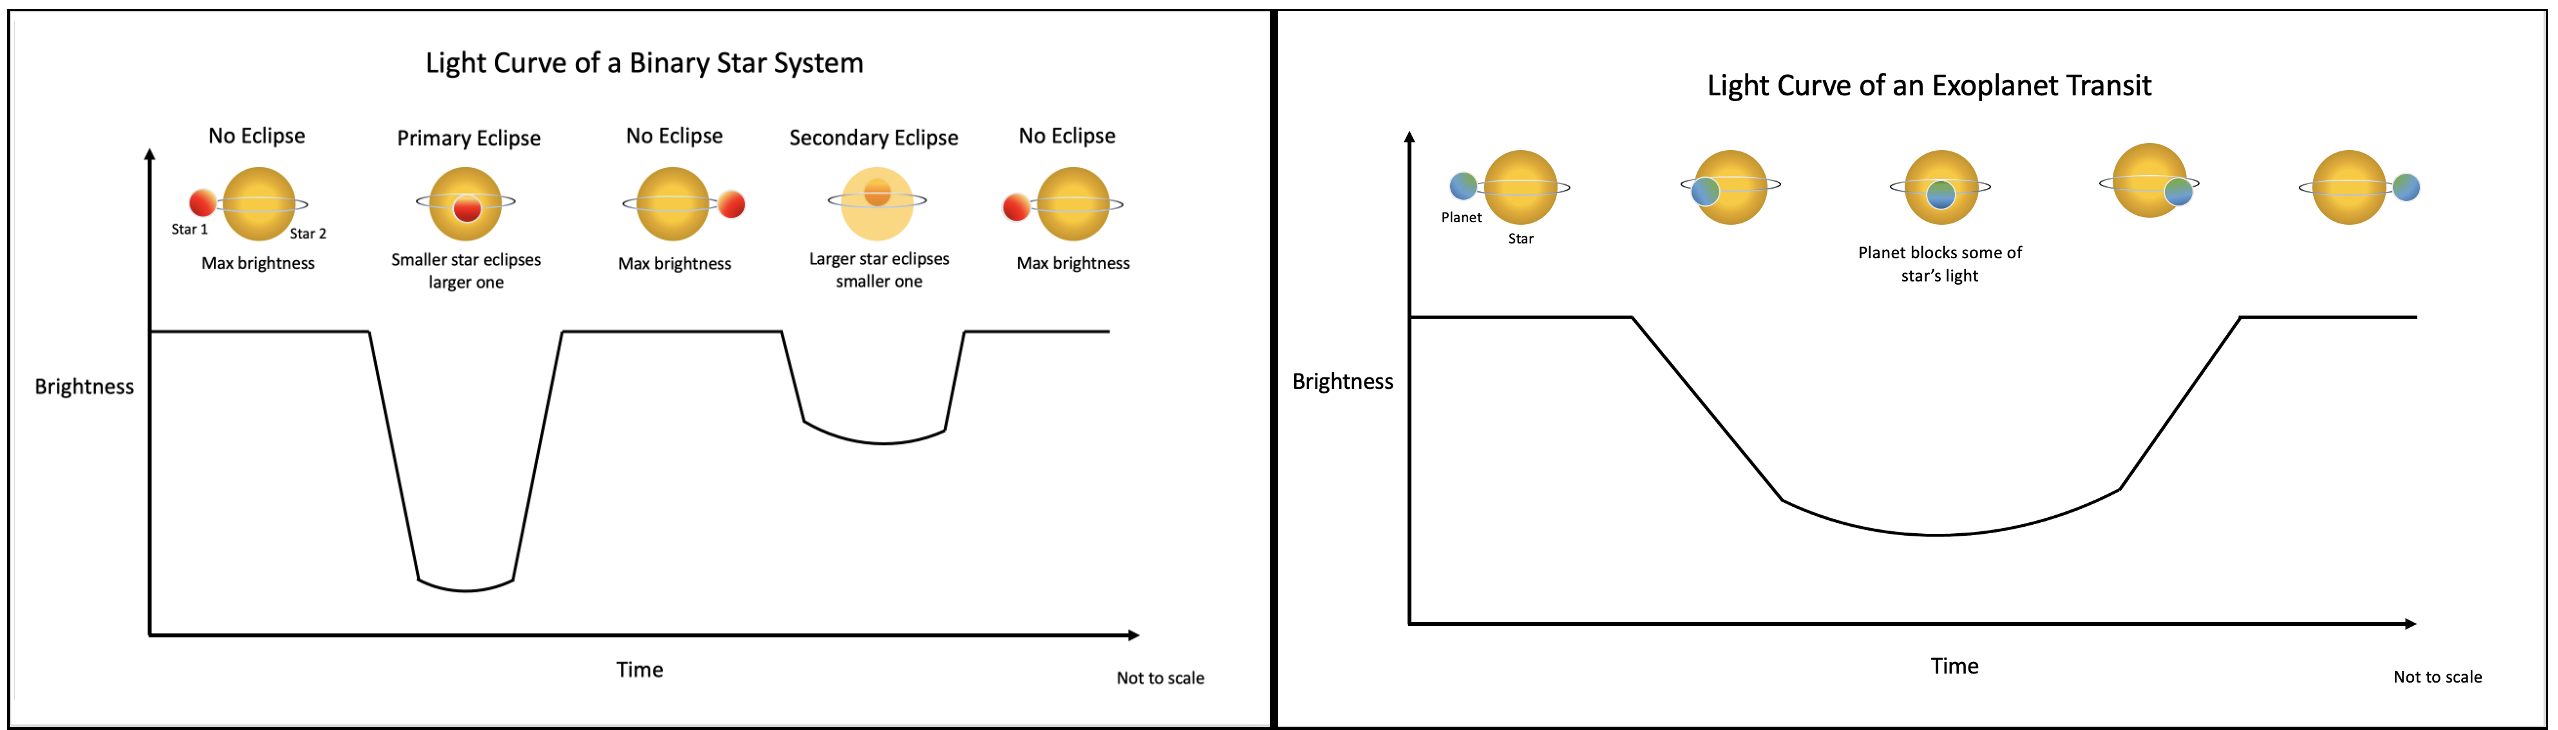

### Ways to Retrieve and Create Light Curves
Looking at the known binary system KIC 1026032, we will first retrieve all observations of the system that we would like to use. There are four primary ways to do so:

#### Astroquerying for Data Retrieval for Light Curves

This method offers more room to control and customize what data targets, collection, and type you would like retrieves. This is due to the flexibility of *.query_criteria* method as you can use only one filter or multiple at once and it will only retrieve information on files that meet all inputted criteria. You can check out more TESS product filters than just the ones demonstrated below with these [Tips and Tricks for Getting TESS Data](https://outerspace.stsci.edu/display/TESS/7.0+-+Tips+and+Tricks+to+Getting+TESS+Data+At+MAST).


The magic command of *%%time* at the top of the cell times how long the entire cell takes to run and returns that time. Both in order to compare the possible methods of data retrieval to each other and be able to see the advantages of using the cloud, each method's cell will be timed.

In [6]:
%%time
# Times how long the cell takes to run

# Retrieving the data directly using astroquery
obs = Observations.query_criteria(objectname="KIC 1026032", obs_collection="TESS", dataproduct_type="timeseries")

# Pick which products we want to retrieve
data_prod = Observations.get_product_list(obs)
filt_prod = Observations.filter_products(data_prod, description="Light curves")

# Download the product from cloud
manifest = Observations.download_products(filt_prod, cloud_only=True)

INFO: Found cached file ./mastDownload/TESS/tess2019198215352-s0014-0000000122784501-0150-s/tess2019198215352-s0014-0000000122784501-0150-s_lc.fits with expected size 1964160. [astroquery.mast.cloud]
INFO: Found cached file ./mastDownload/TESS/tess2019198215352-s0014-0000000137099260-0150-s/tess2019198215352-s0014-0000000137099260-0150-s_lc.fits with expected size 1964160. [astroquery.mast.cloud]
INFO: Found cached file ./mastDownload/TESS/tess2021175071901-s0040-0000000122679547-0211-s/tess2021175071901-s0040-0000000122679547-0211-s_lc.fits with expected size 2062080. [astroquery.mast.cloud]
INFO: Found cached file ./mastDownload/TESS/tess2021175071901-s0040-0000000122784501-0211-s/tess2021175071901-s0040-0000000122784501-0211-s_lc.fits with expected size 2062080. [astroquery.mast.cloud]
INFO: Found cached file ./mastDownload/TESS/tess2021175071901-s0040-0000000122784720-0211-s/tess2021175071901-s0040-0000000122784720-0211-s_lc.fits with expected size 2062080. [astroquery.mast.cloud]


In addition, if we were to deactivate the cloud datasets, essentially turning TIKE into a typical Jupyter notebook, then the data will need to travel through a fiber optic cable from the non-cloud data servers in Baltimore, MD to the cloud servers, including TIKE, in Virginia, which will drastically slow down the process. Now let's time how long the data retrieval takes when we don't take advantage of the cloud: 

In [3]:
# Disabling the cloud datasets, so will now pull data from classic, on-premises archive in Baltimore
Observations.disable_cloud_dataset()

In [4]:
%%time
# Times how long the cell takes to run

# Retrieving the data directly using astroquery
obs = Observations.query_criteria(objectname="KIC 1026957", obs_collection="TESS", dataproduct_type="timeseries")

# Pick which products we want to retrieve
data_prod = Observations.get_product_list(obs)
filt_prod = Observations.filter_products(data_prod, description="Light curves")

# Download the product from cloud
manifest = Observations.download_products(filt_prod)

INFO: Found cached file ./mastDownload/TESS/tess2019198215352-s0014-0000000122784501-0150-s/tess2019198215352-s0014-0000000122784501-0150-s_lc.fits with expected size 1964160. [astroquery.query]
INFO: Found cached file ./mastDownload/TESS/tess2019198215352-s0014-0000000137099260-0150-s/tess2019198215352-s0014-0000000137099260-0150-s_lc.fits with expected size 1964160. [astroquery.query]
INFO: Found cached file ./mastDownload/TESS/tess2021175071901-s0040-0000000122784501-0211-s/tess2021175071901-s0040-0000000122784501-0211-s_lc.fits with expected size 2062080. [astroquery.query]
INFO: Found cached file ./mastDownload/TESS/tess2021175071901-s0040-0000000122784720-0211-s/tess2021175071901-s0040-0000000122784720-0211-s_lc.fits with expected size 2062080. [astroquery.query]
INFO: Found cached file ./mastDownload/TESS/tess2021175071901-s0040-0000000122785104-0211-s/tess2021175071901-s0040-0000000122785104-0211-s_lc.fits with expected size 2062080. [astroquery.query]
INFO: Found cached file .

Without using the cloud, it takes around 12 seconds. With the cloud, it takes only around 4 seconds. Here, using TIKE and the cloud data it takes only 1/3 of the time! When it is on the scale of seconds perhaps it may feel less significant, but remember that we are only retrieving around 15 files here. Were we downloading on scale of hundreds thousands or more files, as many researchers and scientists do in surveys and papers, it would be many minutes and potentially large parts of an hour that TIKE is saving! And every second counts and can add up. 

Note that if you are getting that the cloud-deactivated download was faster, then it was run immediately after the cloud-activated download and thus is simply picking up the already-retrieved files. In that case, you can try running it again in just a moment or restart the kernel. In an attempt to avoid this, the target is switched between downloads to an equivalent eclipsing binary with the same amount of data.

In [7]:
# Reenabling the cloud datasets moving forward
Observations.enable_cloud_dataset()

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


#### *Lightkurve* TPFs Data Retrieval

The next method utilizes *lightkurve*, a package developed specifically for the Kepler and TESS missions to make it easier to look at their light curves and identify transit signals. As long as you have already enabled cloud datasets, *lightkurve* **will** use the cloud datasets automatically and thus give the advantage of the cloud speediness when used to retrieve data.

In [8]:
%%time
# Times how long the cell takes to run

# Downloading the raw pixel files using lightkurve
tpf_collection = lk.search_targetpixelfile("KIC 1026032", cadence='long').download_all(cloud_only=True)
print(tpf_collection);

TargetPixelFileCollection of 17 objects:
    0: KeplerTargetPixelFile Object (ID: 1026032)
    1: KeplerTargetPixelFile Object (ID: 1026032)
    2: KeplerTargetPixelFile Object (ID: 1026032)
    3: KeplerTargetPixelFile Object (ID: 1026032)
    4: KeplerTargetPixelFile Object (ID: 1026032)
    5: KeplerTargetPixelFile Object (ID: 1026032)
    6: KeplerTargetPixelFile Object (ID: 1026032)
    7: KeplerTargetPixelFile Object (ID: 1026032)
    8: KeplerTargetPixelFile Object (ID: 1026032)
    9: KeplerTargetPixelFile Object (ID: 1026032)
    10: KeplerTargetPixelFile Object (ID: 1026032)
    11: KeplerTargetPixelFile Object (ID: 1026032)
    12: KeplerTargetPixelFile Object (ID: 1026032)
    13: KeplerTargetPixelFile Object (ID: 1026032)
    14: KeplerTargetPixelFile Object (ID: 1026032)
    15: KeplerTargetPixelFile Object (ID: 1026032)
    16: KeplerTargetPixelFile Object (ID: 1026032)
CPU times: user 1.62 s, sys: 76.2 ms, total: 1.7 s
Wall time: 2.49 s


As you can see, using *lightkurve* is more expedient and simpler to use, however offers less customizability (although still quite a bit). Beneath the cover, *lightkurve* is actually just using *astroquery* and like the previous method.

Note: For searching for exoplanet transits specifically through light curves, TESS data would generally be better for most targets due to the telescope having less (not none) instrumental noise and because the telescope's mission is to observe the entire sky (it has observed 93% at the time of this writing). Exceptions to this are if the target is distant and dim, due to Kepler observing the same patch of sky for longer than TESS, or it was a highly-anticipated, mission-specific Kepler target, in which case Kepler may have made significantly more observations. More information on the differences between the two telescopes can be found on this citizen science project [TESS versus Kepler page](https://blog.planethunters.org/2019/01/30/kepler-vs-tess/).

In [9]:
tpf = lk.search_targetpixelfile("KIC 1026032", mission="TESS", cadence='long', quarter=10).download()

To better visualize the data we are actually importing with the raw pixel files, let's plot it below.

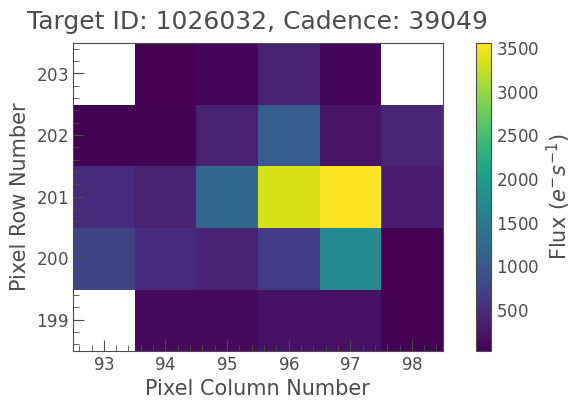

In [10]:
tpf.plot();

TPF is the abbreviation for target pixel files, which are the rawest, most unprocessed data available on the MAST Archive that is still target-specific. For the time allotted to the target (typically 2 minutes or 20 seconds), TESS measures the pixels of a predefined mask and then packages it as a time series of images in a binary FITS table. These pixel files can then be used to create light curves, as we are going to do in this tutorial. You can find more detail on TPF files and other data products with [the TESS Data Products docs page](https://heasarc.gsfc.nasa.gov/docs/tess/data-products.html). 

One of the key advantages of this method is you can choose was aperture mask you want to use on the TPF file when turning it into a light curve or you can even create your own which you can find the steps for in this [Lightkurve Custom Aperture Tutorial](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-1-custom-aperture-photometry.html). However, in this example the pipeline mask was used so it will return the same plot as if you use the last method for retrieving light curves.

To search for exoplanetary transits, we first have to convert the TPF file into a light curve, which we will do using the *to_lightcurve()* method:

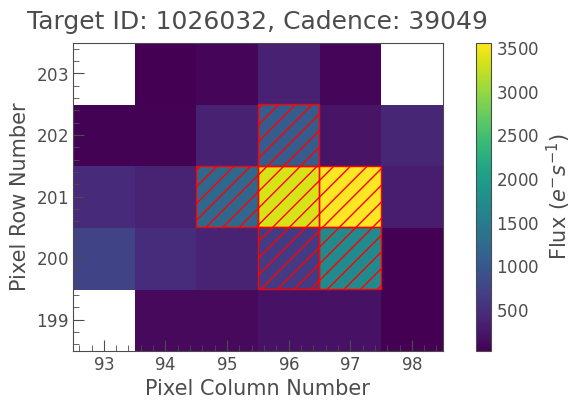

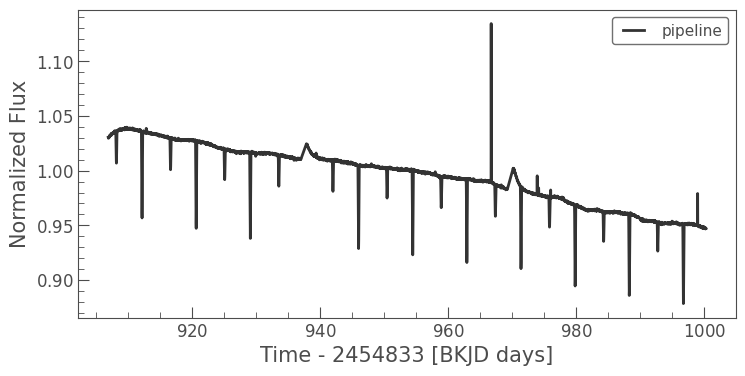

In [11]:
# Applying the standard lightkurve pipeline mask
tpf.plot(aperture_mask='pipeline');

# Normalizing the light curve
ax = tpf.to_lightcurve(aperture_mask = 'pipeline').normalize().plot(label='pipeline', linewidth=2);

#### *Lightkurve* Light Curves Data Retrieval

This next method for data retrieval uses *lightkurve* again but jumps straight to retrieving pre-generated light curves. All the processing to get to a light curve is done for you but at the same time you can not customize the masks used or way these light curves are produced. Also, since we are still using *lightkurve* that will pull from cloud datasets, we get the increased speed for this data retrieval method too.

SearchResult containing 17 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 01 2009 Kepler    1800 kplr001026032      0.0
  1 Kepler Quarter 02 2009 Kepler    1800 kplr001026032      0.0
  2 Kepler Quarter 03 2009 Kepler    1800 kplr001026032      0.0
  3 Kepler Quarter 04 2010 Kepler    1800 kplr001026032      0.0
  4 Kepler Quarter 05 2010 Kepler    1800 kplr001026032      0.0
  5 Kepler Quarter 06 2010 Kepler    1800 kplr001026032      0.0
  6 Kepler Quarter 07 2010 Kepler    1800 kplr001026032      0.0
  7 Kepler Quarter 08 2011 Kepler    1800 kplr001026032      0.0
  8 Kepler Quarter 09 2011 Kepler    1800 kplr001026032      0.0
  9 Kepler Quarter 10 2011 Kepler    1800 kplr001026032      0.0
 10 Kepler Quarter 11 2012 Kepler    1800 kplr001026032      0.0
 11 Kepler Quarter 12 2012 Kepler    1800 kplr0

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

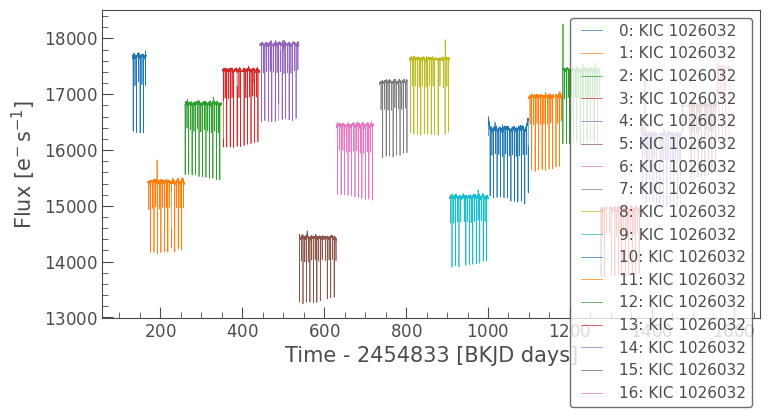

In [12]:
# Directly retrieving light curves for the target
search_result = lk.search_lightcurve('KIC 1026032', author='Kepler', cadence='long')
print(search_result)
lc_collection = search_result.download_all()
lc_collection.plot()

The obvious benefit of this method is you can retrieve the data and plot it in 2-3 steps, however you have far less ability to customize how your data is processed with it automatically going through the pipeline aperture mask.

As a final processing steps before we can see the finished light curve, we will stitch together all the light curve segements, visualized in the above graph with different colors, to get one large light curve.

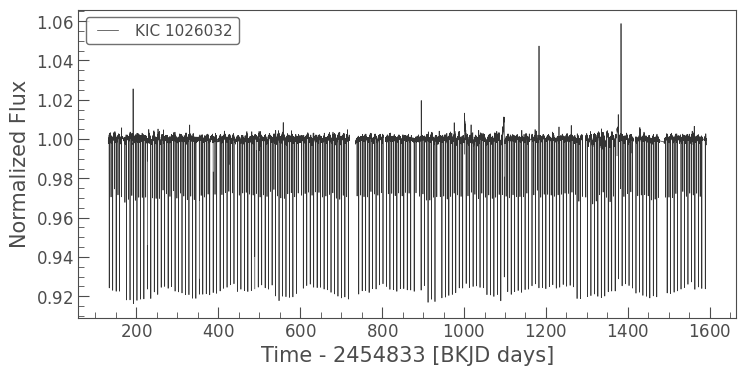

In [13]:
lc = lc_collection.stitch()
lc.plot();

#### Calling File By Name from Cloud Data Retrieval

The best way to retrieve files *by name* from the cloud is through the s3f3 package that lets us use Python commands. The *fs.get()* command will get the files whose path and name you put in the parentheses. 

Depending on what type of data product you are seeking, the file name format is different. A complete table of all data file name formats can be viewed on the [TESS Data Products page](https://archive.stsci.edu/missions-and-data/tess/data-products) and you can fill in the template with the target ID, telescope name, etc. to retrieve your file. Alternatively, if you notice the file names typed below to import by name are the same that *astroquery* gives in the above section on [Astroquerying for Data Retrieval for Light Curves](#Astroquerying-for-Data-Retrieval-for-Light-Curves). So, one could retrieve the names of the files they want with *astroquery* and then download it with s3f3.

If you open the file browser icon to the left to this notebook's folder and then run the below cell, you can see the fits files appear as they are being retrieved.

In [14]:
%%time
# Times how long the cell takes to run

fs.get('s3://stpubdata/tess/public/tid/s0014/0000/0001/2278/4501/tess2019198215352-s0014-0000000122784501-0150-s_lc.fits', 'KIC 1026032 file 1')
fs.get('s3://stpubdata/tess/public/tid/s0014/0000/0001/3709/9260/tess2019198215352-s0014-0000000137099260-0150-s_lc.fits', 'KIC 1026032 file 2')
fs.get('s3://stpubdata/tess/public/tid/s0040/0000/0001/2267/9547/tess2021175071901-s0040-0000000122679547-0211-s_lc.fits', 'KIC 1026032 file 3')
fs.get('s3://stpubdata/tess/public/tid/s0040/0000/0001/2278/4501/tess2021175071901-s0040-0000000122784501-0211-s_lc.fits', 'KIC 1026032 file 4')
fs.get('s3://stpubdata/tess/public/tid/s0040/0000/0001/2278/4720/tess2021175071901-s0040-0000000122784720-0211-s_lc.fits', 'KIC 1026032 file 5')
fs.get('s3://stpubdata/tess/public/tid/s0040/0000/0001/2278/5104/tess2021175071901-s0040-0000000122785104-0211-s_lc.fits', 'KIC 1026032 file 6')
fs.get('s3://stpubdata/tess/public/tid/s0040/0000/0001/2278/5299/tess2021175071901-s0040-0000000122785299-0211-s_lc.fits', 'KIC 1026032 file 7')
fs.get('s3://stpubdata/tess/public/tid/s0040/0000/0001/3709/9260/tess2021175071901-s0040-0000000137099260-0211-s_lc.fits', 'KIC 1026032 file 8')
fs.get('s3://stpubdata/tess/public/tid/s0041/0000/0001/2267/9547/tess2021204101404-s0041-0000000122679547-0212-s_lc.fits', 'KIC 1026032 file 9')
fs.get('s3://stpubdata/tess/public/tid/s0041/0000/0001/2278/4501/tess2021204101404-s0041-0000000122784501-0212-s_lc.fits', 'KIC 1026032 file 10')
fs.get('s3://stpubdata/tess/public/tid/s0041/0000/0001/2278/4720/tess2021204101404-s0041-0000000122784720-0212-s_lc.fits', 'KIC 1026032 file 11')
fs.get('s3://stpubdata/tess/public/tid/s0041/0000/0001/2278/5104/tess2021204101404-s0041-0000000122785104-0212-s_lc.fits', 'KIC 1026032 file 12')
fs.get('s3://stpubdata/tess/public/tid/s0041/0000/0001/2278/5299/tess2021204101404-s0041-0000000122785299-0212-s_lc.fits', 'KIC 1026032 file 13')
fs.get('s3://stpubdata/tess/public/tid/s0041/0000/0001/3709/9260/tess2021204101404-s0041-0000000137099260-0212-s_lc.fits', 'KIC 1026032 file 14')
fs.get('s3://stpubdata/tess/public/tid/s0054/0000/0001/2267/9547/tess2022190063128-s0054-0000000122679547-0227-s_lc.fits', 'KIC 1026032 file 15')
fs.get('s3://stpubdata/tess/public/tid/s0054/0000/0001/2278/5104/tess2022190063128-s0054-0000000122785104-0227-s_lc.fits', 'KIC 1026032 file 16')

CPU times: user 249 ms, sys: 85 ms, total: 334 ms
Wall time: 3.05 s


[None]

Notice that this or *astroquery* is by *far* the fastest method of retrieving the data. They take well under half the time of any of the other cloud methods and a sixth of the time that off-cloud downloading from MAST method takes. When the time scale is on the range of seconds as with these examples as we are only getting around 15 files, this means which method you choose is more personal preference. However, were you to want to get many more files, the time would start to add up, so *s3f3* or *astroquery* method is the best for bulk data downloads.

But why is that? To understand that, we need to look at what each method of getting data is actually doing beneath the commands. Below is a simplified diagram of the scenario:

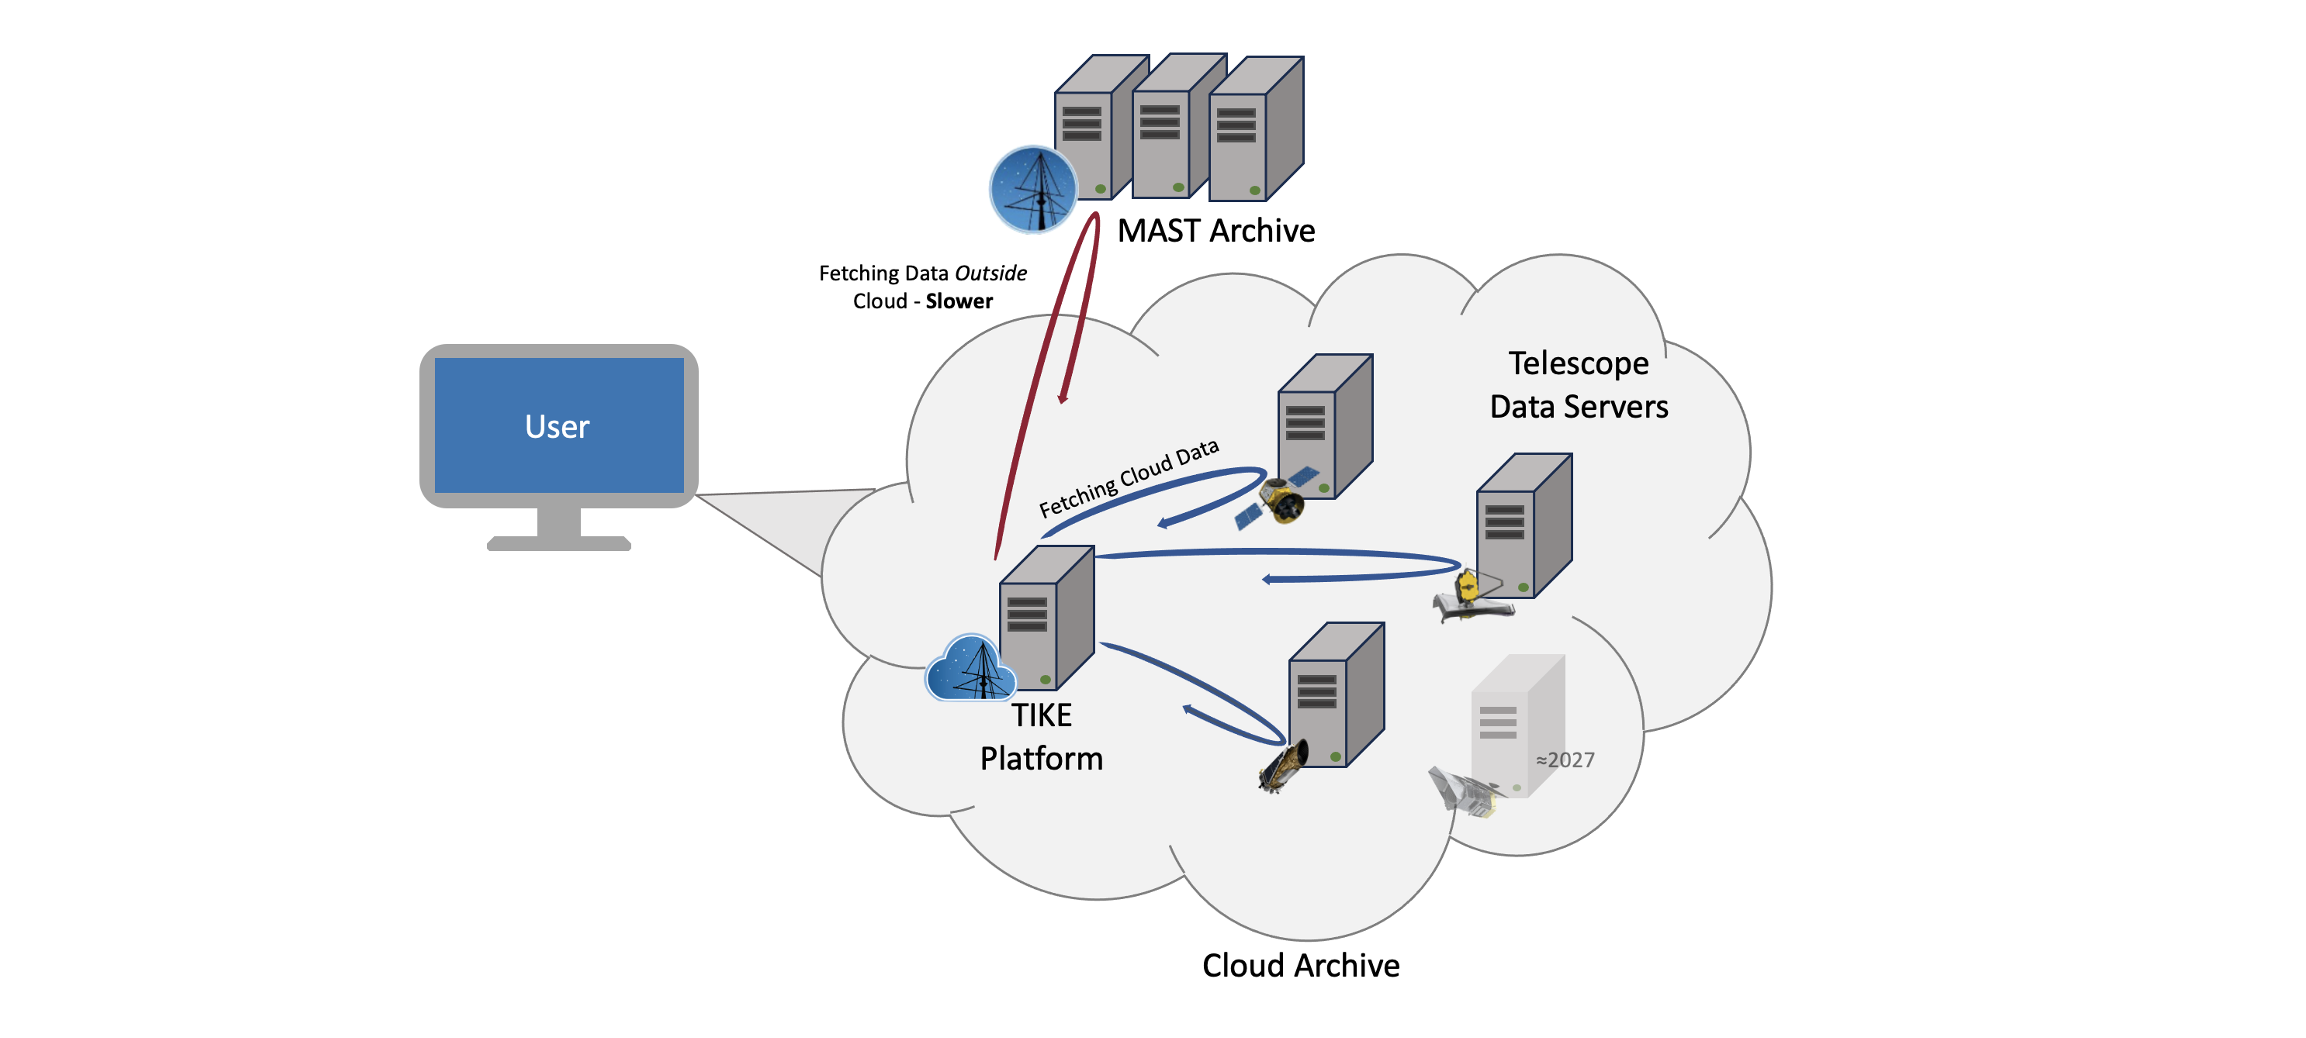

Essentially when we use packages built on astroquery, they should automatically default to the cloud data servers. So when TIKE users sign in to use the cloud datasets, they are running their code using the TIKE servers and when they call for data from cloud datasets, TIKE fetched it from nearby telescope data servers before returning it to the user. Everything stays contained within the cloud. However, with other packages if their source codes include calls to the MAST Archive, TIKE will be forced to fetch data from MAST servers that are not in the cloud, which can slow it down. While we hope to these packages will be updated for the cloud, s3f3 is an Python interface built specifically for the cloud, so will never do this, meaning all data requests and code will remain in the cloud, which will always be fastest.

As a last note on data retrievals and the different types of files and what can be pulled from them, *lightkurve* can be used to read downloaded files when given their name and then returns a table with the information contained within, showing the headers that one can use to draw data from the file:

In [15]:
%%time
# Times how long the cell takes to run

# Lightkurve can also be used to read these files
lk.read('KIC 1026032 file 1')

CPU times: user 126 ms, sys: 3.98 ms, total: 130 ms
Wall time: 144 ms


time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1683.356975010856,2.1641980e+03,1.3612906e+01,3.0726232e-03,328247,500.44738,540.86392,4.2533965e+03,1.1090554e+01,1.6786830e+03,4.8799763e+00,2.1641980e+03,1.3612906e+01,0,———,———,———,———,500.44738,2.1040083e-03,540.86392,1.6480626e-03,1.7027663e-02,2.4478702e-02
1683.3583639033438,2.1611763e+03,1.3556463e+01,3.0726274e-03,328248,500.44765,540.86460,4.2473296e+03,1.1044570e+01,1.6761865e+03,4.8738742e+00,2.1611763e+03,1.3556463e+01,0,———,———,———,———,500.44765,2.1031068e-03,540.86460,1.6387420e-03,1.5524867e-02,2.6786370e-02
1683.3597527955992,2.1744678e+03,1.3563353e+01,3.0726313e-03,328249,500.44921,540.86471,4.2586606e+03,1.1050182e+01,1.6753291e+03,4.8712244e+00,2.1744678e+03,1.3563353e+01,0,———,———,———,———,500.44921,2.1001520e-03,540.86471,1.6363275e-03,2.0511063e-02,2.7280064e-02
1683.3611416880865,2.1696423e+03,1.3572531e+01,3.0726355e-03,328250,500.45004,540.86741,4.2543247e+03,1.1057660e+01,1.6777283e+03,4.8826790e+00,2.1696423e+03,1.3572531e+01,0,———,———,———,———,500.45004,2.1020637e-03,540.86741,1.6381450e-03,1.9502822e-02,3.1425372e-02
1683.3625305805735,2.1809143e+03,1.3585215e+01,3.0726397e-03,328251,500.45053,540.86231,4.2646074e+03,1.1067993e+01,1.6705409e+03,4.8884463e+00,2.1809143e+03,1.3585215e+01,0,———,———,———,———,500.45053,2.0967210e-03,540.86231,1.6362497e-03,2.0962946e-02,2.1738047e-02
1683.3639194728287,2.1570737e+03,1.3560890e+01,3.0726437e-03,328252,500.44857,540.86186,4.2452812e+03,1.1048177e+01,1.6673724e+03,4.8735833e+00,2.1570737e+03,1.3560890e+01,0,———,———,———,———,500.44857,2.1092470e-03,540.86186,1.6406978e-03,1.9990861e-02,2.5292922e-02
1683.3653083653164,2.1491919e+03,1.3560496e+01,3.0726478e-03,328253,500.44835,540.86967,4.2331353e+03,1.1047855e+01,1.6766897e+03,4.8765068e+00,2.1491919e+03,1.3560496e+01,0,———,———,———,———,500.44835,2.1120927e-03,540.86967,1.6464466e-03,2.1196950e-02,3.1832922e-02
1683.3666972575718,2.1672703e+03,1.3552189e+01,3.0726518e-03,328254,500.44827,540.86414,4.2547085e+03,1.1041086e+01,1.6706544e+03,4.8680935e+00,2.1672703e+03,1.3552189e+01,0,———,———,———,———,500.44827,2.1017781e-03,540.86414,1.6341034e-03,2.0658825e-02,2.8492425e-02


### Comparing Binary and Exoplanet Transit Light Curves
#### Turning a Light Curve into a Periodogram
*lightkurve* has a quite convenient method *to_periodogram* that will convert the light curve into a periodogram in one step, allowing you to select a method and input the period and frequency factor. For fully customizing the method of converting to a periodogram, one can see [this *lightkurve* periodogram tutorial](http://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html). For the sake of this comparison between binary and exoplanet transit light curves, the method BLS will be used to clearly be able to visualize the difference. BLS stands for Box Least Squares, a box-fitting algorithm with statistical properties that can be applied to the photometric time series of a star to search for exoplanet transits. More on BLS can be found in how the original [Kovács et al. 2002](https://ui.adsabs.harvard.edu/abs/2002A%26A...391..369K/abstract) paper on how the statistics work and in the [*astropy* docs](https://docs.astropy.org/en/stable/timeseries/bls.html) on its applications. 

Note that BLS is NOT an optimal method to apply alone to binary light curves to obtain values, one must first subtract the binary sine curve to get any exoplanet transits, as will be done in a later section, however it does serve the purpose of illustrating how the eclipse signals might be mistaken for exoplanetary transits.

<Quantity 8.46014601 d>

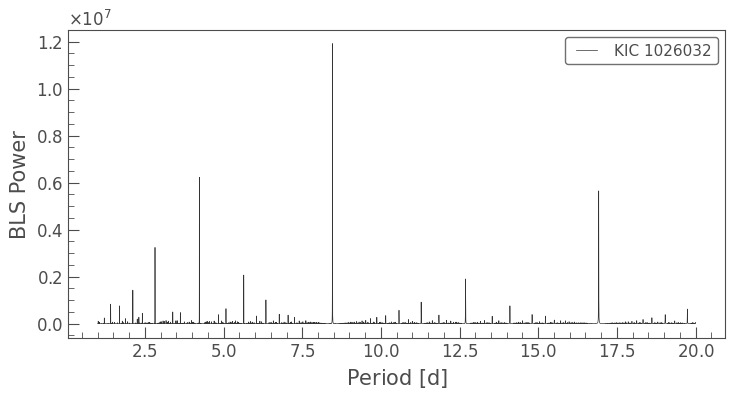

In [16]:
# Using BLS to turn it into a periodogram
period = np.linspace(1, 20, 10000)
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

# Calculating most likely parameters if there is an exoplanet from periodogram
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power
planet_b_period

The actual period of this binary system as given in the [MAST Table of Kepler Eclipsing Binaries](https://archive.stsci.edu/kepler/eclipsing_binaries.html) is 8.460438 days, so from just from a handful of code lines and graphs we are easily able to get the period of an eclipsing binary to 0.0003% error accuracy! 
While the pipeline does a good job in general, this is a particularly low error for it.

Exercise 1: KIC 1161345 is another binary star system, this time with an even smaller period. Try importing its light curves and see if you can find the binary period.

However, when we apply a transit mask designed to help visualize where an exoplanet transit may be occuring, the model mistakes the period of the binary stars as the period of an exoplanet, as seen below. Note that astronomers have known about this binary system for well over a decade and completed many observations of it, while not impossible it is highly unlikely that this binary system has any orbiting exoplanets and that is certainly not what the transit mask is identifying.

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

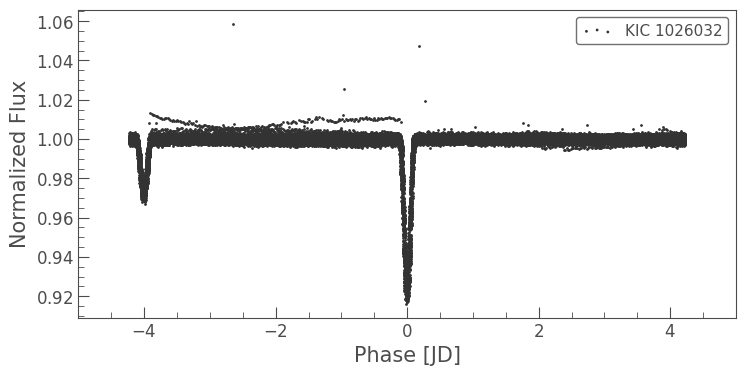

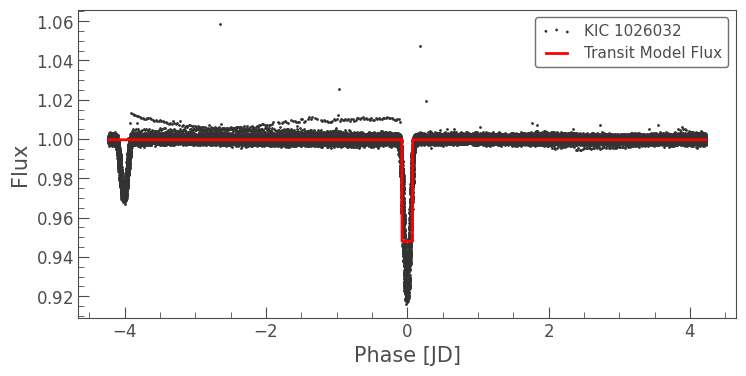

In [17]:
# Folding the light curve to see if there is a strong transit signal
ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
ax.set_xlim(-5, 5);

# Creating a cadence mask to use to visualize the most likely transit fit
planet_b_mask = bls.get_transit_mask(period=planet_b_period, transit_time=planet_b_t0, duration=planet_b_dur)

# Creating a BLS model from the parameters calculated above
planet_b_model = bls.get_transit_model(period=planet_b_period, transit_time=planet_b_t0, duration=planet_b_dur)
ax = lc.fold(planet_b_period, planet_b_t0).scatter()

# Using the BLS model overlayed on the folded light curve to visualize the transit
planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2)

Also, visible in the light curve very clearly are both the shallower secondary eclipse and deeper primary eclipse dips.

For reference of what an exoplanet transit around a single star looks like and why the transit model is mistakenly finding one in the binary system, let us look at Kepler-19, a standard star with multiple, confirmed transiting exoplanets.

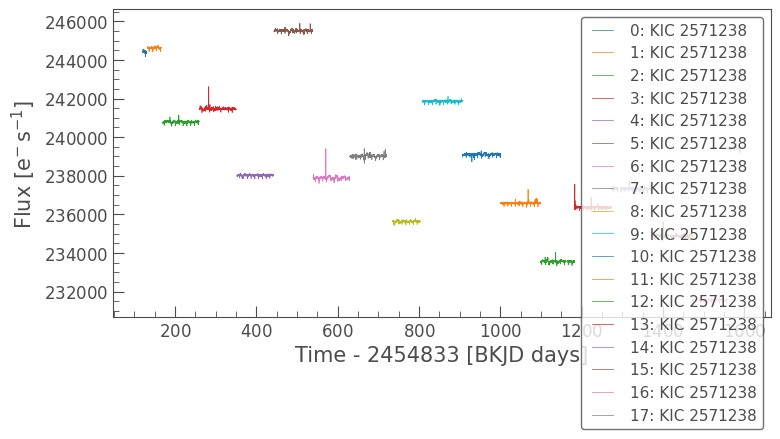

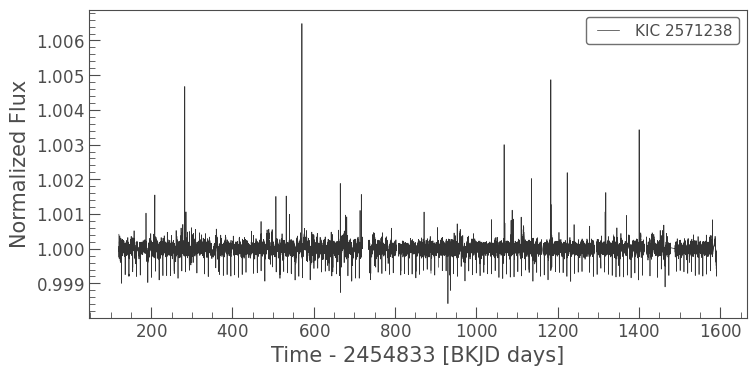

In [18]:
# Retrieving light curves, plotting and stitching them
search_result = lk.search_lightcurve('Kepler-19', author='Kepler', cadence='long')
lc_collection = search_result.download_all()
lc_collection.plot();
lc = lc_collection.stitch().flatten(window_length=901)
lc.plot();

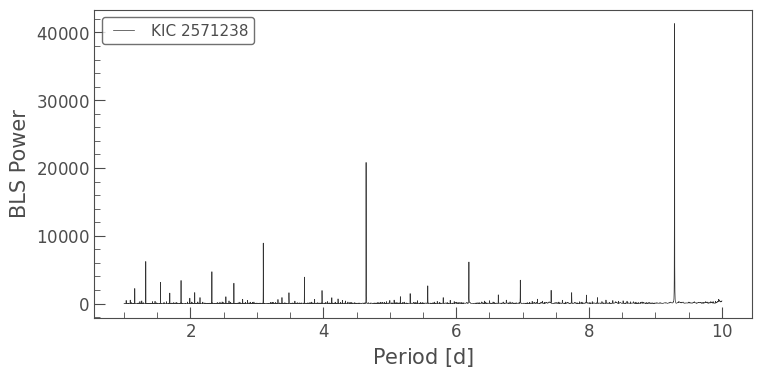

In [19]:
# Turning the light curve into a periodogram
period = np.linspace(1, 10, 10000)
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

# Calculating likely parameters of the exoplanet
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

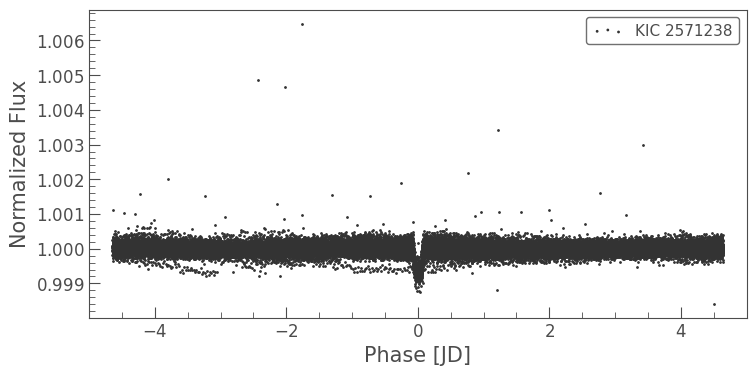

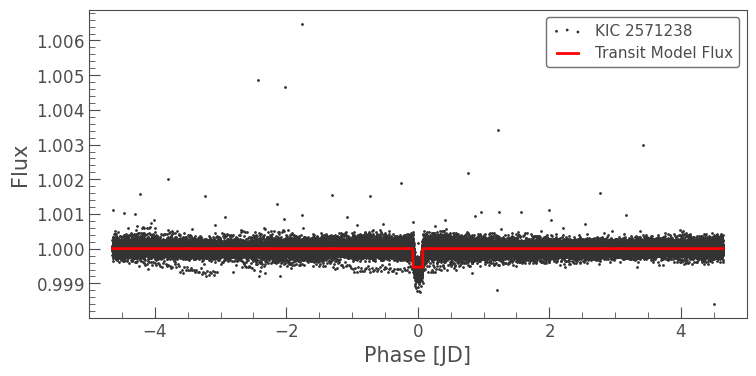

In [20]:
# Folding the light curve to see the transit signal
ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
ax.set_xlim(-5, 5);

# Applying a mask to visualize a transit fit
planet_b_mask = bls.get_transit_mask(period=planet_b_period, transit_time=planet_b_t0, duration=planet_b_dur)

# Creating a BLS model and overlaying it to visualize the transit
planet_b_model = bls.get_transit_model(period=planet_b_period, transit_time=planet_b_t0, duration=planet_b_dur)
ax = lc.fold(planet_b_period, planet_b_t0).scatter()
planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-5, 5);

As you can see both the binary star system's eclipses and the exoplanet's transit in front of its host start are exhibitited in the respective periodograms with the noticeable dip in the scatter pattern, hence why it is understandable that the transit mask would mistake them and is something to be cautious of and watch for.

#### Looking at the Data with an Interactive Interface
Another way to work with the data files is through the *lightkurve* interactive interface with the method *.interact()*. The interface allows for instantaneous selection of pixel masks or the pixels themselves and the instantaneous generation of the resulting light curve or aperture photometry. Additionally, one of the key advantages is that the TPFs and light curves are displayed right next to each other and you can interact with them simultaneously with hovering over sections of the data displaying tooltips and dragging sliders to change your location in the data. 

In [21]:
tpf = lk.search_targetpixelfile("KIC 1026032", mission="TESS", cadence='long', quarter=10).download()
tpf.interact()

Another useful interactive tool from *lightkurve* is the method *.interact_bls()* that allows you to interact with the BLS periodogram of the inputted light curve.

In [22]:
lc = lk.search_lightcurve("KIC 1026032", mission="TESS", cadence='long', quarter=10).download()
lc.interact_bls()

For further information on the interactive *lightkurve* interface, you can see this [*lightkurve* TPF Interactive Inspection tutorial](https://docs.lightkurve.org/tutorials/1-getting-started/interactively-inspecting-data.html).

### Subtracting Non-Planetary Signals to Reveal Exoplanetary Transit

There is also the situation in which one is trying to detect the exoplanet transit around a *binary* host star. For this, we must subtract the sine wave of the binary stars orbiting each other to be able to search for the dip of the exoplanet transit. Let's use Kepler-35, a binary star system known to have an orbiting exoplanet.

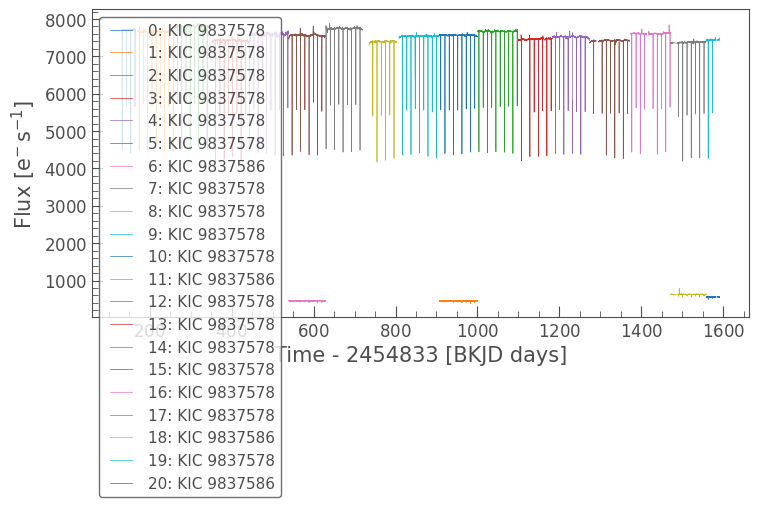

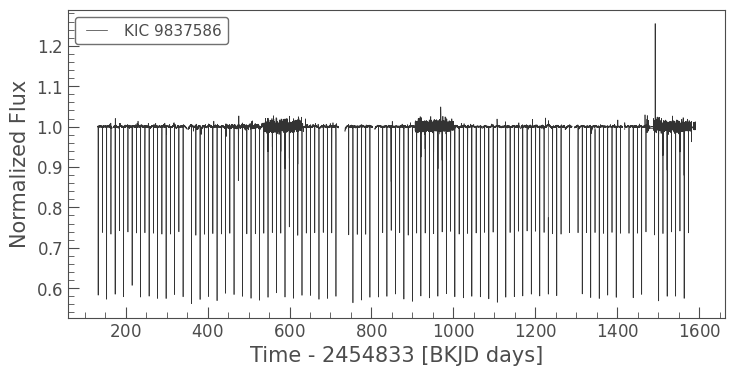

In [23]:
# Retrieving target's light curves
search_result = lk.search_lightcurve('Kepler 35', author='Kepler', cadence='long')
lc_collection = search_result.download_all()
lc_collection.plot();

# Stitching individual observations together
lc = lc_collection.stitch().flatten(window_length=901)
lc.plot();

In [24]:
# Importing time and flux values from light curve to arrays
info = lc.normalize()
t = Table(rows=info, meta={'name': 'data table'})
cols = t.columns
flux = cols[1]
time = cols[0]
fluxes = flux.data
time_series = time.value

Now that we have the data that we know contains a circumbinary planet, we must subtract the binary star eclipses from the light curve in order to see the exoplanet transit. First, let us subtract the primary eclipse:

In [25]:
first = []

# Iterating through beginning section of array of fluxes to find first primary eclipse
for i in range(len(fluxes)):
    if flux[i] < 0.70 and 100 < time_series[i] < 150:
        first.append(time_series[i])

# Finding the average time where the first primary eclipse occurs
print(first)
avg_time = sum(first)/len(first)
print(avg_time)

[132.81979605850938, 132.84023054780846, 132.8606648369896, 132.88109922616422]
132.85044766736792


For our intents and purposes, quite accurate transit period estimates can be obtained by setting flux and time series limits based on the light curve graph above. For searching for the first primary eclipse of this binary system, we are looking for the first significant drop in flux, hence why the time series bounds are set to be between 100 and 150, right at the beginning of the light curve on the graph. 

In [26]:
# Creating a mask that checks for a significant flux dip at the calculated primary eclipse location
transit_occur = lc.create_transit_mask(transit_time=avg_time, period=20.73, duration=6)
print(transit_occur)
print(sum(transit_occur))

[ True  True  True ... False False False]
22154


In [27]:
# Initializing an array for the fluxes that we will subtract the primary eclipse dips from
flux_array = lc.flux.value.tolist()

# Iterating through array of flux and if primary eclipse flux dip is detected, flux is added back to remove the dip
for i in range(len(flux_array)):
    if transit_occur[i] == True and fluxes[i] < 0.98:
        flux_array[i] = (1 - flux_array[i]) + flux_array[i]

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

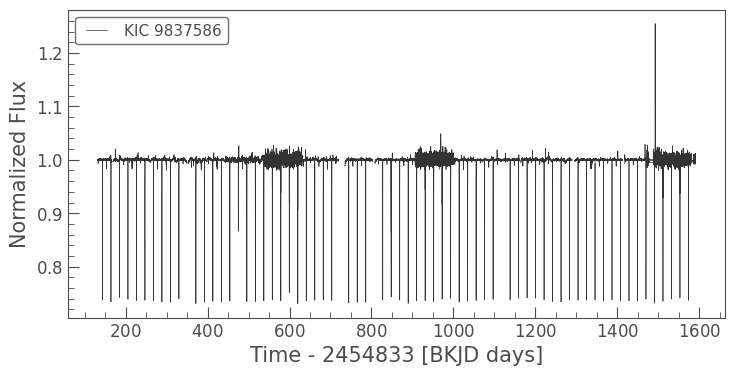

In [29]:
# Assigning flux of the light curve to be the array with the primary eclipses subtracted
lc.flux = flux_array
t = Table
col = Column(flux_array, name='replace flux')
lc.plot()

As you can now see in the plot above, the largest periodic drops in flux which were the primary eclipses are no longer there as we subtracted them. Now, onto subtracting the secondary eclipses:

In [30]:
# Reimporting values from light curve to arrays so we are subtracting from the no-primary data
info = lc.normalize()
t = Table(rows=info, meta={'name': 'data table'})
cols = t.columns
flux = cols[1]
time = cols[0]

fluxes = flux.data
time_series = time.value

In [31]:
second = []

# Iterating through beginning, but slightly later section of array of fluxes to find first secondary eclipse
for i in range(len(fluxes)):
    if fluxes[i] < 0.90 and 100 < time_series[i] < 150:
        second.append(time_series[i])

# Finding the average time where the first secondary eclipse occurs
avg_time = sum(second)/len(second)
print(avg_time)
transit_occur = lc.create_transit_mask(transit_time=avg_time, period=20.73, duration=6)
print(transit_occur)
sum(transit_occur)

143.33214611325334
[False False False ... False False False]


22594

In [33]:
# Initializing an array for the fluxes that we will subtract the secondary eclipse dips from
flux_array = lc.flux.value.tolist()

# Iterating through array of flux and if secondary eclipse flux dip is detected, flux is added back to remove the dip
for i in range(len(flux_array)):
    if transit_occur[i] == True and fluxes[i] < 0.98:
        flux_array[i] = (1 - flux_array[i]) + flux_array[i]

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

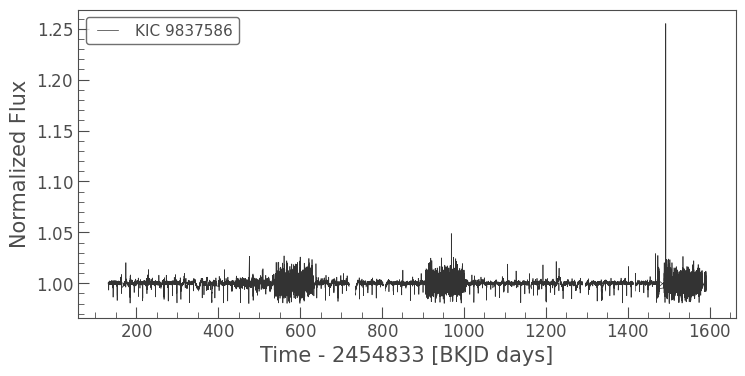

In [35]:
# Assigning flux of the light curve to be the array with the secondary eclipses subtracted
lc.flux = flux_array
t = Table
col = Column(flux_array, name='replace flux')
lc.plot()

As you can now see in the plot above, the largest remaining periodic drops in flux which were the secondary eclipses are no longer there as we subtracted them. Now, the binary star system influence on the light curve is subtracted, so we can begin to search the light curve for the exoplanet transit now:

<Quantity 132.97995992 d>

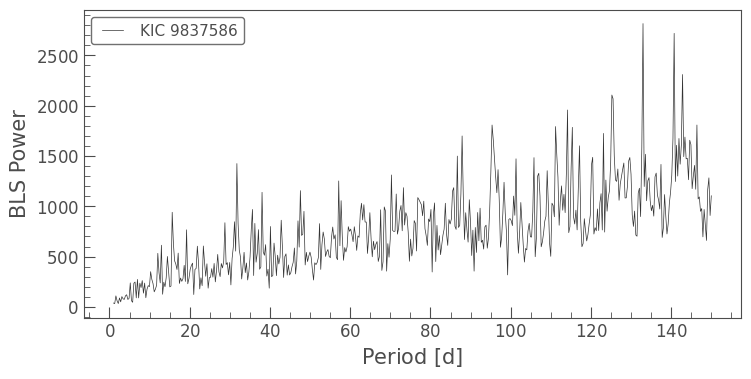

In [36]:
# Turning light curve into a periodogram
period = np.linspace(1, 150, 500)
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

# Calculating most likely parameters if there is an exoplanet from periodogram
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power
planet_b_period

The actual orbital period of Kepler-35b is 131.458 days, so this method got pretty close with around a 1.16% error. Now, let's see what the predicted period from the original data would have been were the binary signals not subtracted from the light curve:

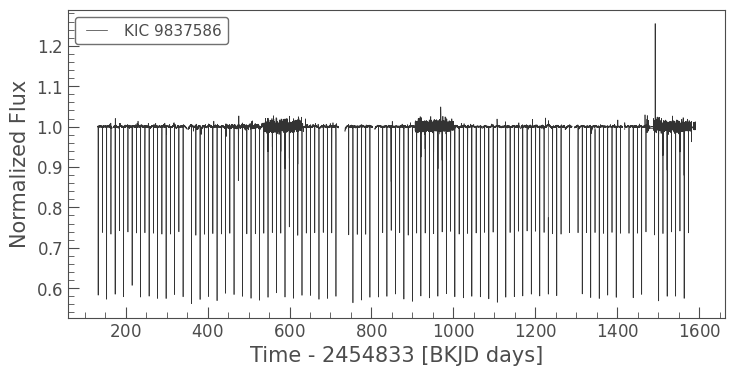

In [37]:
# Retrieving target's light curves
search_result = lk.search_lightcurve('Kepler 35', author='Kepler', cadence='long')
lc_collection = search_result.download_all()

# Stitching individual observations together
lc = lc_collection.stitch().flatten(window_length=901)
lc.plot();

<Quantity 62.21242485 d>

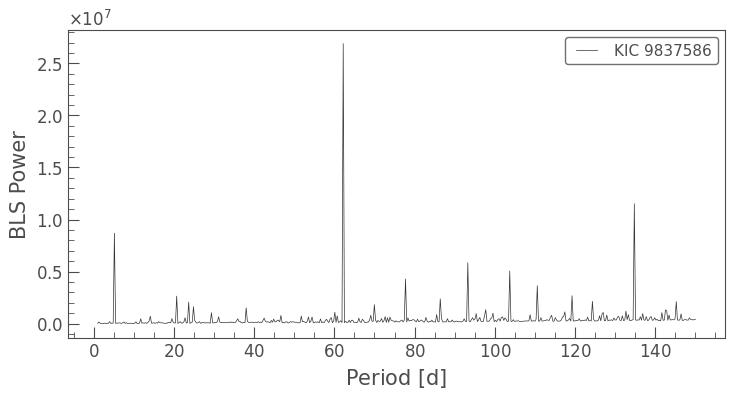

In [38]:
# Turning light curve into a periodogram
period = np.linspace(1, 150, 500)
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

# Calculating most likely parameters if there is an exoplanet from periodogram
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power
planet_b_period

You can see that if the binary signal is not accounted for and subtracted, the method picks up the binary primary eclipse signal as the exoplanet spike is significantly smaller and drowned out. This causes the method to  incorrectly identify the binary eclipse as an exoplanet transit, returning an incorrect period that is off by over 50%. Thus while above method does require some additional steps, its return in the accuracy of period predictions for circumbinary exoplanets makes it worth it. Now give it a try yourself:

Exercise 2: Kepler-47 is one of the first discovered multiplanetary circumbinary system! This means that it has multiple exoplanets orbiting binary stars. Import the Kepler-47 data, subtract the binary primary and secondary eclipses, then search for the exoplanets. 

Hint: See if you can find three, one with a shorter period (<50 days) and two with longer periods (>150 days). 

Exercise 3 (Open-Ended): Kepler-64b is a planet that orbits within not just a binary system with two stars orbiting around each other, but a *quadruple* star system with four stars orbiting each other! See if you can subtract the quadruple influence and find the period of the exoplanet. When you think you have it, check your period against [NASA's Exoplanet Exploration page for Kepler 64b](https://exoplanets.nasa.gov/resources/222/kepler-64b-four-star-planet/).

### False Transit Positives
As noted at the beginning of this notebook, binary stars themselves are often falsely identified as transiting exoplanets. In addition to earlier showing why that mistake might occur, historically let's look at TIC 291308749 which was first identified to be a transiting exoplanet by the survey before being flagged as a false positive by a later study looking to confirm suspected exoplanets: 

/opt/conda/envs/tess/lib/python3.8/site-packages/lightkurve/collections.py:213: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_flux', 'sap_bkg_err', 'sap_bkg'}
  warnings.warn(


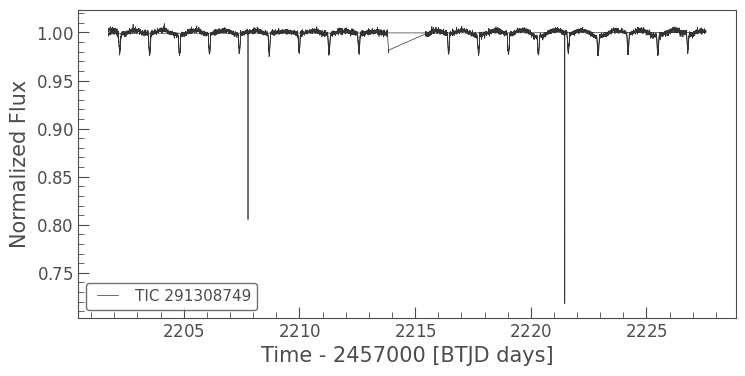

In [39]:
search_result = lk.search_lightcurve('TIC 291308749')
lc_collection = search_result.download_all()
lc = lc_collection.stitch().flatten(window_length=901)
lc.plot(normalize=True)

As you can see above, *lightkurve* returns a warning on the code that certain columns are being excluded from the stitching due to the fact that they are incompatible with the types that *lightkurve* takes. However, since for our purposes the column needed is 'flux' and *lightkurve* is finding 'flux' compatible and stitching it, which can be seen in the axes of the plot returned and can also be checked by running *lc.info()* in a cell below, the warning and exclusion of the other columns is fine as it still plots what was wanted. In general, some of these types of warning may occur when working with TESS data and *lightkurve* due to *lightkurve* being a package compatible with both TESS and Kepler data and TESS data having some additional columns compared to Kepler due to both telescope instrumentation and processing pipeline differences. If you don't want to see the warnings, you can simply add a line that filters warnings and ignores them, so they are not returned to the user.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

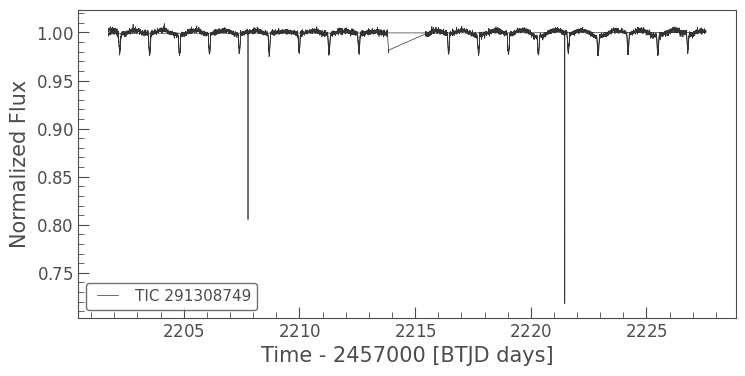

In [40]:
# Ignoring warnings
warnings.simplefilter('ignore')

search_result = lk.search_lightcurve('TIC 291308749')
lc_collection = search_result.download_all()
lc = lc_collection.stitch().flatten(window_length=901)
lc.plot(normalize=True)

One can very clearly see the two large drops, one smaller and the other larger, that show that it is a binary system with secondary and primary eclipses that result in the two flux drops. However, in addition, very clear to the eye are smaller, regular periodic dips in the flux that was intially flagged as an exoplanet. However, it turned out to be a false positive with no actual transiting exoplanet. In this study, the false positives were categorized and this specific one was found to be due to that the light curve is that of a [single-lined spectroscopic binary](https://phys.libretexts.org/Bookshelves/Astronomy__Cosmology/Celestial_Mechanics_(Tatum)/18%3A_Spectroscopic_Binary_Stars), which means that the radial motion of only one of the two stars can be detected. Other potential categories of false positives include variable stars, nearby eclipsing binary that influenced the flux received, blend in follow up aperture, etc. To see all the categories and the study on false transit positives, see the original paper [Collins et al. 2018](https://iopscience.iop.org/article/10.3847/1538-3881/aae582) paper.

Also, please do note that as with most any observational data there may be instrumental noise. Specifically, instrumental noise and light scattering can cause trends that have in the past been known to be flagged as objects of interest and potential exoplanet transits when in fact they are not. If you would like to correct for instrumental noise from TESS (most common telescope used to search for exoplanet transits as of time of notebook's writing), you can see this [Noise Removal TESS notebook](https://heasarc.gsfc.nasa.gov/docs/tess/NoiseRemoval.html).

## Additional Resources

Here are some additional resources to check out if you are interested in diving further in:

- [MAST API](https://mast.stsci.edu/api/v0/index.html)
- [TESS Archive Manual](https://outerspace.stsci.edu/display/TESS/TESS+Archive+Manual)
- [Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf)
- [List of Kepler Binaries](https://archive.stsci.edu/kepler/eclipsing_binaries.html)

## Citations
If you use any of the following open source softwares or resources for published research, please cite. Follow these links for more information about citing them:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)
* [Citing MAST data](https://archive.stsci.edu/publishing/data-attributions)


## About this Notebook

**Author(s):** Larom Segev, Thomas Dutkiewicz <br>
**Keyword(s):** TIKE, Cloud archive, Astroseismology, Binary stars, Exoplanet transits <br>
**Last Updated:** July 2023 <br>
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 